In [1]:
%matplotlib inline

In [2]:
from time import sleep

import io
import numpy as np
import requests
import skimage.io
import matplotlib.pyplot as plt
from art.utils import to_categorical
from art.estimators.classification import BlackBoxClassifier
from art.attacks.evasion import HopSkipJump, SquareAttack

# Load images

In [3]:
def load_image(image_path):
    with open(image_path, 'rb') as f:
        image_bytes = f.read()
    image = skimage.io.imread(image_bytes, plugin='imageio')

    return image

In [4]:
def get_image_bytes(image):
    file_stream = io.BytesIO()
    skimage.io.imsave(file_stream, image.astype(np.uint8), plugin='imageio', format='png')
    image_bytes = file_stream.getvalue()
    
    return image_bytes

In [5]:
image = load_image('../artifacts/data/strawberry.jpg')

In [6]:
image.shape

(100, 100, 3)

In [7]:
image.dtype

dtype('uint8')

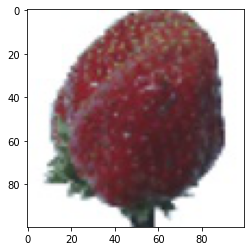

In [8]:
plt.imshow(image)
plt.show()

# Create classifier

In [10]:
service_url = 'https://aidefenderpoc.cognitiveservices.azure.com/customvision/v3.0/Prediction/dea344c1-4682-43a7-9b26-26c246191a47/classify/iterations/Iteration1/image'

In [11]:
classes = [
    'Negative',
    'strawberry',
    'fig',
    'avacado',
    'mandarin',
    'cherry',
    'tomato',
    'potato',
    'lemon',
    'pear',
    'banana',
    'Lychee',
]
classes_idx = {c:i for i, c in enumerate(classes)}
classes_idx_rev = {i:c for i, c in enumerate(classes)}

In [12]:
def customvision_predict_batch(images):
    labels = [customvision_predict(img) for img in images]
    return to_categorical(labels, nb_classes=len(classes))

In [21]:
def customvision_predict(image):
    image_bytes = get_image_bytes(image)
    
    r = requests.post(
        service_url, 
        headers={
            'Prediction-Key': '4ec44febef0d4c8eaee4843b16ad5c9d',
            'Content-Type': 'application/octet-stream',        
        },
        data = image_bytes
    )
    response = r.json()
    
    label = response['predictions'][0]['tagName']
    label_id = classes_idx[label]
    
    sleep(0.1)
    
    return label_id

In [22]:
customvision_predict(image.astype(np.float32))

1

In [23]:
customvision_predict_batch([image])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [24]:
classifier = BlackBoxClassifier(customvision_predict_batch, image.shape, len(classes), clip_values=(0, 255))
classifier.channels_first=False

# AutoAttack

In [25]:
attack = SquareAttack(estimator=classifier, norm=2, max_iter=5000, eps=800, p_init=0.8, nb_restarts=5)
x_adv = attack.generate(x=np.array([image.astype(np.float32)]))

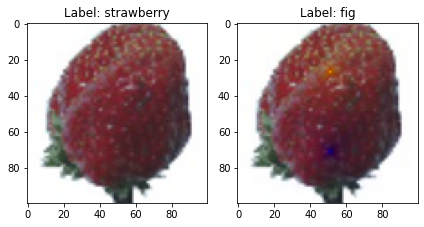

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2)

image_label_id = customvision_predict(image.astype(np.float32))
image_label = classes_idx_rev[image_label_id]

image_adv_label_id = customvision_predict(x_adv[0])
image_adv_label = classes_idx_rev[image_adv_label_id]

ax1.imshow(image)
ax2.imshow(x_adv[0].astype(np.uint8))

ax1.set_title(f'Label: {image_label}')
ax2.set_title(f'Label: {image_adv_label}')

fig.tight_layout()

# HopSkipJump

In [28]:
?HopSkipJump


Adversarial image at step 0. L2 error 6775.65 and class label 2.


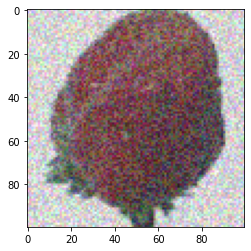


Adversarial image at step 10. L2 error 2460.7905 and class label 11.


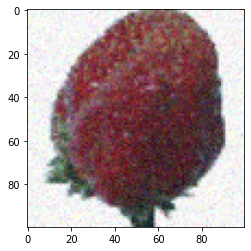


Adversarial image at step 20. L2 error 1066.2911 and class label 11.


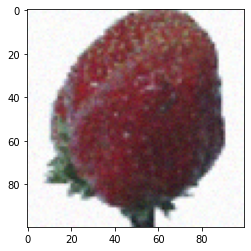

In [29]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None
for i in range(3):
    x_adv = attack.generate(x=np.array([image.astype(np.float32)]), x_adv_init=x_adv)
    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0].astype(np.uint8))
    plt.show()
    
    attack.max_iter = iter_step

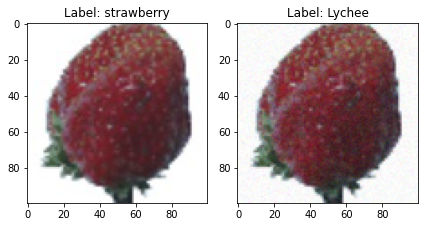

In [30]:
fig, (ax1,ax2) = plt.subplots(1, 2)

image_label_id = customvision_predict(image.astype(np.float32))
image_label = classes_idx_rev[image_label_id]

image_adv_label_id = customvision_predict(x_adv[0])
image_adv_label = classes_idx_rev[image_adv_label_id]

ax1.imshow(image)
ax2.imshow(x_adv[0].astype(np.uint8))

ax1.set_title(f'Label: {image_label}')
ax2.set_title(f'Label: {image_adv_label}')

fig.tight_layout()